# Assessing and Enhancing Property Quality Rating

## 1: Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


## 2: Load the Dataset

In [5]:
# Load dataset
df = pd.read_excel('C:\\Users\\ashut\\OneDrive\\Desktop\\Data(RS)\\Precision_ Property_Insights.xlsx')

# Check the first few rows of the dataset
df.head(2)

,cid,dayhours,price,room_bed,room_bath,living_measure,lot_measure,ceil,coast,sight,...,City,State,Country,zipcode,lat,long,living_measure15,lot_measure15,furnished,total_area
0,3876100940,20150427T000000,600000,4.0,1.75,3050.0,9440.0,1,0,0.0,...,Kirkland,Washington,King,98034,47.7228,-122.183,2020.0,8660.0,0.0,12490
1,3145600250,20150317T000000,190000,2.0,1.00,670.0,3101.0,1,0,0.0,...,Seattle,Washington,King,98118,47.5546,-122.274,1660.0,4100.0,0.0,3771


Dataset contain 21613 rows and 23 columns

## 3: Removing and Update a columns
There is no need for cid (customer ID) in our model. Also, there is no need for lat and long (latitude and longitude) because I have already transformed the data using excel by adding city, state, and country attributes, which were extracted from the zipcode attribute using Chrome. Therefore, zipcode is also not required for our model.

In [8]:
df.drop(columns=["cid", "lat", "long","zipcode"], inplace=True)


There is no need for the old living_measure and lot_measure columns along with their corresponding total_area. I only want to train our model using the updated living_measure15, lot_measure15, and their respective total_area.

In [10]:
# Drop the old measure and total_area  columns
df.drop(['living_measure', 'lot_measure','total_area'], axis=1, inplace=True)


I want to extract the month and year from the dayhours column, add new columns called year and month, and then remove the dayhours column as it is no longer needed.



In [12]:
# First, convert the column to datetime format
df['dayhours'] = pd.to_datetime(df['dayhours'], format='%Y%m%dT%H%M%S')
# Now extract year and month
df['year'] = df['dayhours'].dt.year
df['month'] = df['dayhours'].dt.month


In [13]:
# removing dayhours columns
df.drop('dayhours', axis=1, inplace=True)


I want to add a new column called renovated (Yes or No) to my dataset, based on the yr_renovated column. If the value is 0, the renovated column should have "No", and if the value is greater than 0, it should have "Yes".

In [15]:
df['renovated'] = df['yr_renovated'].apply(lambda x: '1' if x > 0 else '0')
df.drop('yr_renovated', axis=1, inplace=True)

The dataset contains a column called quality_rating. The rating ranges from 1 to 13. Convert the quality_rating into a binary format: 0 for ratings in the range 1 to 7 (minimum quality), and 1 for ratings in the range 8 to 13 (maximum quality). Add this as a new column.

In [17]:
# Convert quality_rating to binary: 0 for 1-7, 1 for 8-13
df['quality_rating'] = df['quality'].apply(lambda x: 1 if x >= 8 else 0)

# Removing quality column
df.drop('quality', axis=1, inplace=True)

## 4: Handle Missing values


Check if dataset contain missing value or not, if yes than replace that value with (mean,median and mode) 
for checking missing value we used a funtion called Isnull().sum()

In [20]:
df.isnull().sum()

price                 0
room_bed            108
room_bath           108
ceil                 42
coast                 1
sight                57
condition            57
ceil_measure          1
basement              1
yr_built              1
City                  0
State                 0
Country               0
living_measure15    166
lot_measure15        29
furnished            29
year                  0
month                 0
renovated             0
quality_rating        0
dtype: int64

In [21]:
print('Dataset contain total 600 null values ')
df.isnull().sum().sum()

Dataset contain total 600 null values 


600

Dataset also contain some junck values($). We have to repalce that junck value with null values.
For checking if dataset containg any junk value we use a function called isin().any()


In [23]:
junk=["$"]
df.isin(junk).any()

price               False
room_bed            False
room_bath           False
ceil                 True
coast                True
sight               False
condition            True
ceil_measure        False
basement            False
yr_built             True
City                False
State               False
Country             False
living_measure15    False
lot_measure15       False
furnished           False
year                False
month               False
renovated           False
quality_rating      False
dtype: bool

Replacing a junk value with a null or Nan value for do so we use a function called replace()

In [25]:
df.replace(["$"],np.nan, inplace=True)


C:\Users\ashut\AppData\Local\Temp\ipykernel_8156\3445198658.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(["$"],np.nan, inplace=True)


In [26]:
print('there is no junk value left')
df.isin(junk).any()

there is no junk value left


price               False
room_bed            False
room_bath           False
ceil                False
coast               False
sight               False
condition           False
ceil_measure        False
basement            False
yr_built            False
City                False
State               False
Country             False
living_measure15    False
lot_measure15       False
furnished           False
year                False
month               False
renovated           False
quality_rating      False
dtype: bool

In [27]:
print('check if there is any null value in dataset')
df.isnull().sum()


check if there is any null value in dataset


price                 0
room_bed            108
room_bath           108
ceil                 72
coast                31
sight                57
condition            85
ceil_measure          1
basement              1
yr_built             15
City                  0
State                 0
Country               0
living_measure15    166
lot_measure15        29
furnished            29
year                  0
month                 0
renovated             0
quality_rating        0
dtype: int64

In [28]:
print('After replacing junk value to null or NaN value the total number null value are in a dataset is 702')
df.isnull().sum().sum()

After replacing junk value to null or NaN value the total number null value are in a dataset is 702


702

In [29]:
df.head(196)
print('In ceil and coast column contain NaN value')

In ceil and coast column contain NaN value


## 5: Fill a Null value with a mean,median,and mode

In [31]:
# filling missing value with median
df.fillna({
    "room_bed": df["room_bed"].median(),
    "room_bath": df["room_bath"].median(),
    "ceil":df["ceil"].median(),
    "yr_built":df["yr_built"].median(),
    "living_measure15": df["living_measure15"].median(),
    "lot_measure15": df["lot_measure15"].median()
    
}, inplace=True)


In [32]:
# add a new colunmn calculate total_area
df['total_area'] = df['living_measure15'] + df['lot_measure15']


In [33]:
# fill null value with mode
df.fillna({
    "sight": df["sight"].mode()[0],
    "condition": df["condition"].mode()[0],
    "coast": df["coast"].mode()[0],
    "furnished": df["furnished"].mode()[0],
}, inplace=True)


In [34]:
# I just want to remove one missing value from the quality, ceil_measure, and basement_measure columns.
df.dropna(subset=['ceil_measure', 'basement'], inplace=True)


Adding a new column called Age_of_the_property, which is calculated as 2016 - yr_built. We are using 2016 as the current year because our dataset contains data from 2015 then there is no need for yrr buil column.

In [36]:
#  add a colunmn called Age of the property
df['yr_built'] = pd.to_numeric(df['yr_built'], errors='coerce')
df['Age_of_the_property'] = 2016 - df['yr_built']
df.drop('yr_built', axis=1, inplace=True)

**What One-Hot Encoding Does:**
 If your coast column contains categories like yes and no (or 1 and 0), one-hot encoding will convert it into one or more columns with binary values (0s and 1s) representing each category.
 
 ---
The dataset contains columns called coast and furnished. Since both coast and furnished are categorical variables, we need to apply one-hot encoding to them.

In [38]:
# Apply one-hot encoding to both columns
df = pd.get_dummies(df, columns=['coast', 'furnished'], drop_first=True)

In [39]:
print('After handling the missing values, my dataset contains no missing values. It consists of 21,612 rows and 22 columns.')
df.isnull().sum().sum()

After handling the missing values, my dataset contains no missing values. It consists of 21,612 rows and 22 columns.


0

In [40]:
df.to_excel("modified_dataset.xlsx", index=False)

## 6: Exploratory Data analysis

Exploratory Data Analysis (EDA) is a critical first step in any data science project. It helps you understand your data's characteristics, identify patterns, detect anomalies, and form hypotheses. Here are the main steps of performing a comprehensive EDA:

---
### 1. Basic data Overview

In [42]:
#Check the shape:
df.shape

(21612, 21)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21612 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                21612 non-null  int64  
 1   room_bed             21612 non-null  float64
 2   room_bath            21612 non-null  float64
 3   ceil                 21612 non-null  float64
 4   sight                21612 non-null  float64
 5   condition            21612 non-null  float64
 6   ceil_measure         21612 non-null  float64
 7   basement             21612 non-null  float64
 8   City                 21612 non-null  object 
 9   State                21612 non-null  object 
 10  Country              21612 non-null  object 
 11  living_measure15     21612 non-null  float64
 12  lot_measure15        21612 non-null  float64
 13  year                 21612 non-null  int32  
 14  month                21612 non-null  int32  
 15  renovated            21612 non-null  obje

In [44]:
df.describe()

,price,room_bed,room_bath,ceil,sight,condition,ceil_measure,basement,living_measure15,lot_measure15,year,month,quality_rating,total_area,Age_of_the_property
count,2.161200e+04,21612.000000,21612.000000,21612.000000,21612.000000,21612.000000,21612.000000,21612.000000,21612.000000,21612.000000,21612.000000,21612.000000,21612.000000,21612.000000,21612.000000
mean,5.401920e+05,3.369517,2.115838,1.494147,0.233759,3.407736,1788.366556,291.522534,1985.937211,12759.894827,2014.322969,6.574449,0.477420,14745.832038,44.988062
std,3.673679e+05,0.928349,0.768397,0.539024,0.765537,0.649942,828.102535,442.580840,683.018313,27269.928975,0.467622,3.115377,0.499501,27403.833542,29.364095
min,7.500000e+04,0.000000,0.000000,1.000000,0.000000,1.000000,290.000000,0.000000,399.000000,651.000000,2014.000000,1.000000,0.000000,1721.000000,1.000000
25%,3.218375e+05,3.000000,1.750000,1.000000,0.000000,3.000000,1190.000000,0.000000,1490.000000,5100.000000,2014.000000,4.000000,0.000000,6980.000000,19.000000
50%,4.500000e+05,3.000000,2.250000,1.500000,0.000000,3.000000,1560.000000,0.000000,1840.000000,7620.000000,2014.000000,6.000000,0.000000,9460.000000,41.000000
75%,6.450000e+05,4.000000,2.500000,2.000000,0.000000,4.000000,2210.000000,560.000000,2360.000000,10080.000000,2015.000000,9.000000,1.000000,12229.250000,65.000000
max,7.700000e+06,33.000000,8.000000,3.500000,4.000000,5.000000,9410.000000,4820.000000,6210.000000,871200.000000,2015.000000,12.000000,1.000000,874620.000000,116.000000


In [45]:
# Group Stats:
num_cols = ['room_bed', 'room_bath', 'living_measure15', 'condition','lot_measure15','total_area','ceil','sight','ceil_measure','basement']
df.groupby('quality_rating')[num_cols].agg(['mean', 'median', 'std'])

room_bed                  room_bath                   \
                    mean median       std      mean median       std   
quality_rating                                                         
0               3.128741    3.0  0.935198  1.708363   1.75  0.630389   
1               3.633068    4.0  0.845585  2.561858   2.50  0.648910   

               living_measure15                     condition  ...      ceil  \
                           mean  median         std      mean  ...       std   
quality_rating                                                 ...             
0                   1622.266867  1570.0  396.626715  3.496458  ...  0.423933   
1                   2384.007850  2307.5  708.346795  3.310622  ...  0.533398   

                   sight                  ceil_measure                      \
                    mean median       std         mean  median         std   
quality_rating                                                               
0               0.099168    0.0  0.486325  1335.004162  1250.0  443.291588   
1               0.381082    0.0  0.962895  2284.613394  2160.0  866.062159   

                  basement                     
                      mean median         std  
quality_rating                                 
0               246.375863    0.0  368.412656  
1               340.939717    0.0  507.014219  

[2 rows x 30 columns]

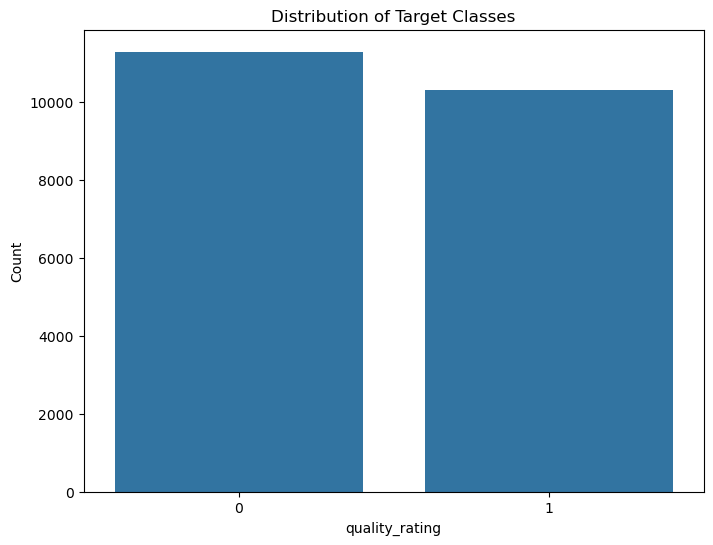

Class proportions:
quality_rating
0    0.52258
1    0.47742
Name: proportion, dtype: float64


In [46]:
# Check if the target variable quality_rating is balanced or not. It seems that it is mostly a balanced class.
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='quality_rating')
plt.title('Distribution of Target Classes')
plt.ylabel('Count')
plt.show()

# Calculate class proportions
target_props = df['quality_rating'].value_counts(normalize=True)
print("Class proportions:")
print(target_props)

### 2. Univariate Analysis of Features

---
**1.1. Numerical Features**
- Use histograms and box plots to inspect distributions.
- Check skewness, outliers, normality—important for choosing the right models and transformations.

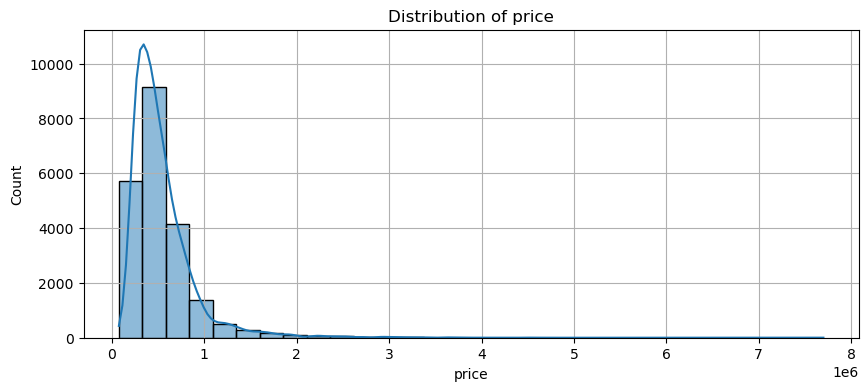

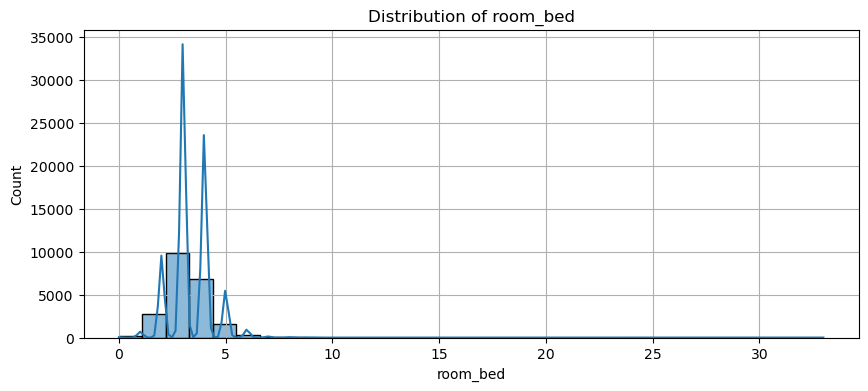

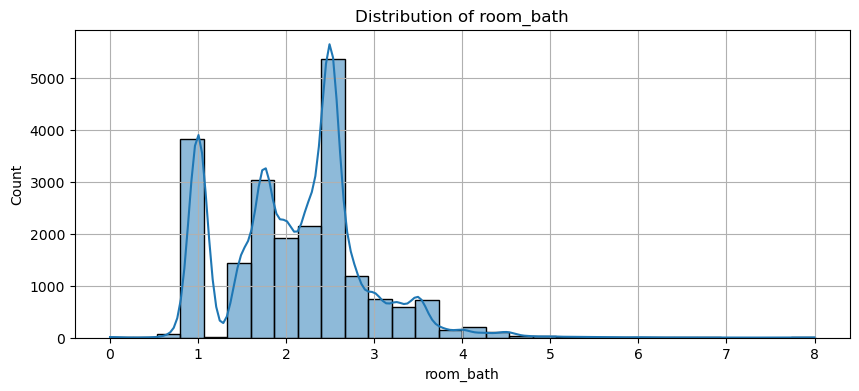

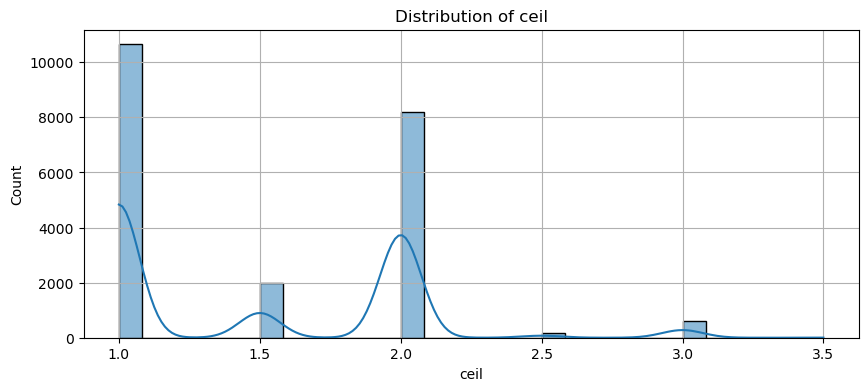

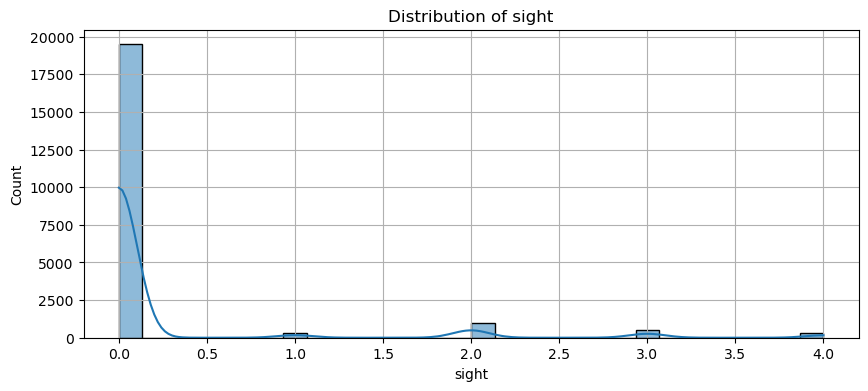

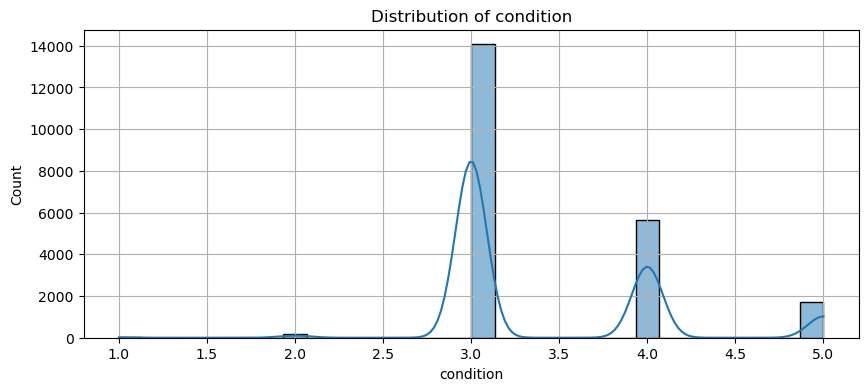

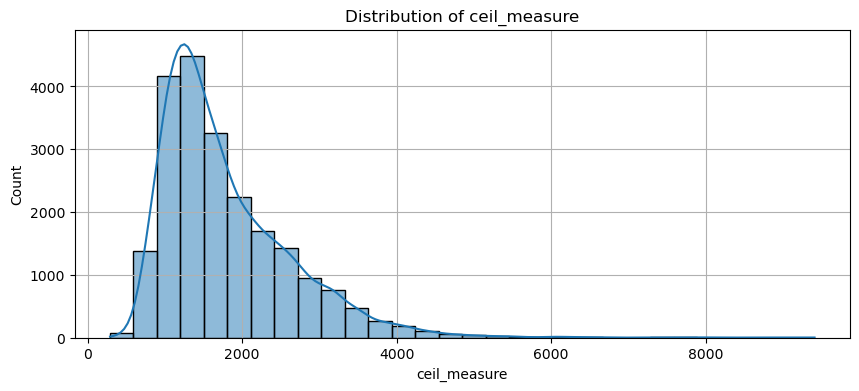

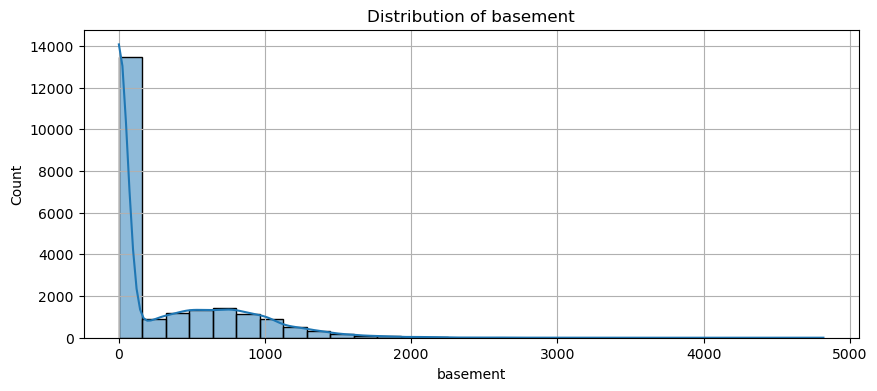

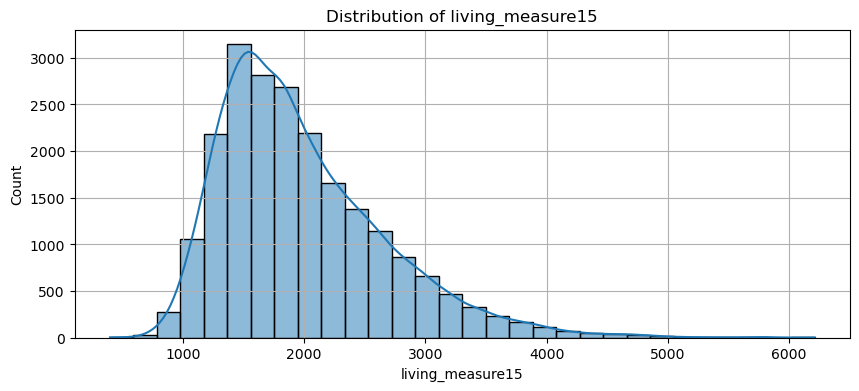

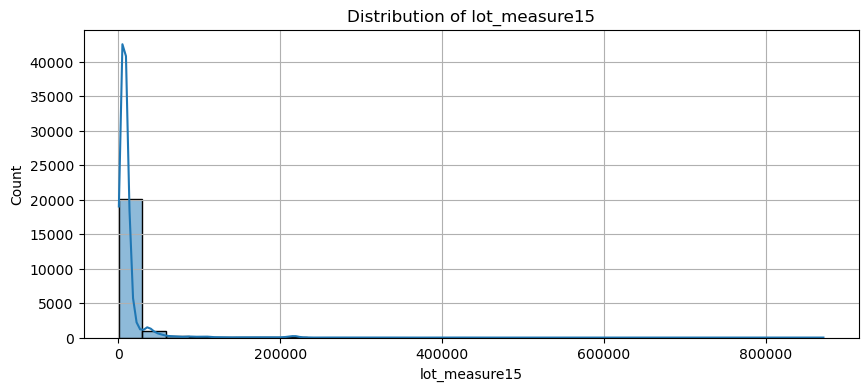

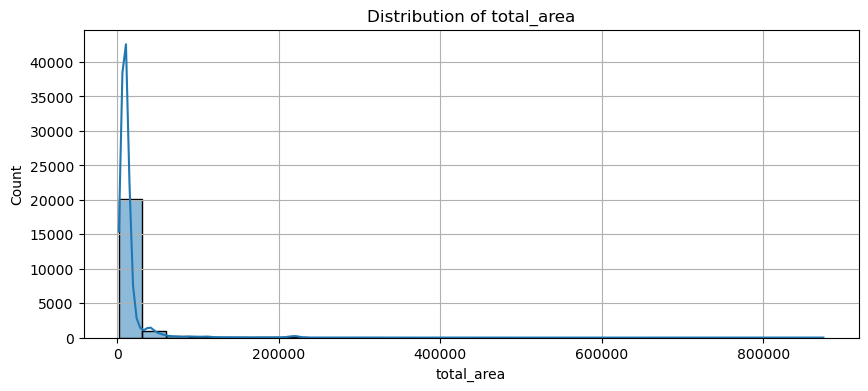

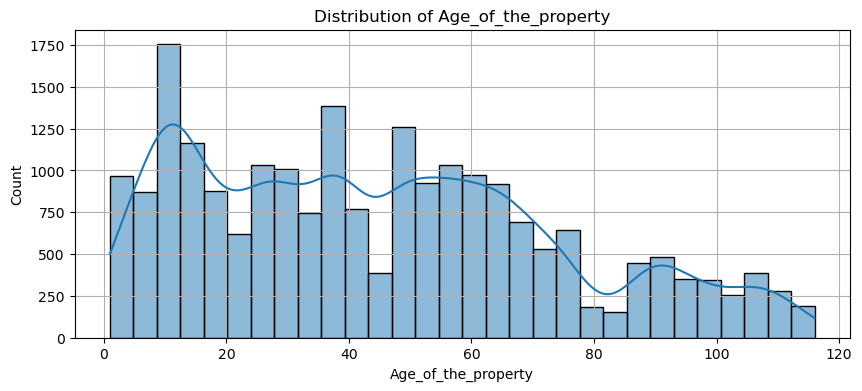

In [48]:
numerical = df.select_dtypes(include=['int64', 'float64']).drop(columns='quality_rating')

for col in numerical.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.grid()
    plt.show()


**1.2. Chi-square Test (Optional for Categorical Features**
-  Low p-values (< 0.05) imply strong dependency between the categorical feature and the target.
-  Since all p-values < 0.05, all three features are significantly associated with the target variable quality_rating.
- This means these categorical features contribute meaningfully to predicting the property’s quality.
- You should keep these variables in your model and use them in feature engineering or model training.


In [50]:
cat_features = ['coast_1.0', 'furnished_1.0', 'renovated']
for col in cat_features:
    table = pd.crosstab(df[col], df['quality_rating'])
    chi2, p, _, _ = chi2_contingency(table)
    print(f'{col} - Chi-square p-value: {p:.4f}')


coast_1.0 - Chi-square p-value: 0.0000
furnished_1.0 - Chi-square p-value: 0.0000
renovated - Chi-square p-value: 0.0120


**2. Visuallise a bar chart between features (coast, furnished, and renovated) and the quality_rating**
- These charts will help you see how each feature influences property quality.
  
---
**2.1. Coast vs. Quality Rating**
- Most homes without a coast view are of low quality.
- Homes with a coast view are mostly high quality.

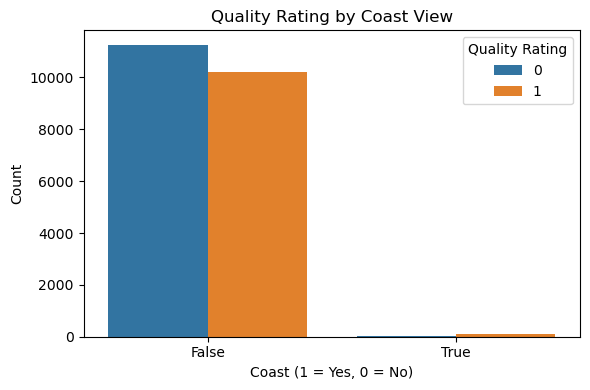

In [52]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='coast_1.0', hue='quality_rating')
plt.title('Quality Rating by Coast View')
plt.xlabel('Coast (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.legend(title='Quality Rating')
plt.tight_layout()
plt.show()


**2.2. Furnished vs. Quality Rating**
- Unfurnished homes tend to be low quality.
- Furnished homes are often high quality.

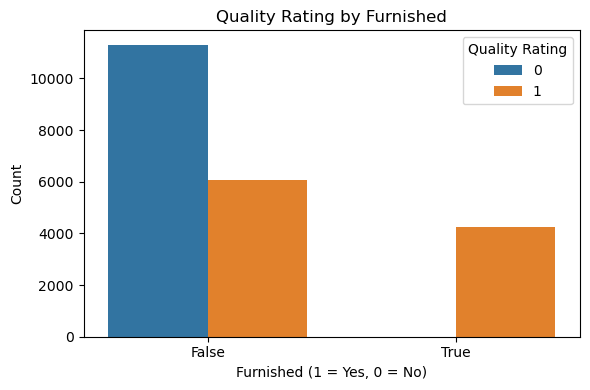

In [54]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='furnished_1.0', hue='quality_rating')
plt.title('Quality Rating by Furnished')
plt.xlabel('Furnished (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.legend(title='Quality Rating')
plt.tight_layout()
plt.show()


**2.3. Renovated vs. Quality Rating**
- Recently renovated homes are more likely to be high quality.
- Renovating adds value, but not as strongly as furnishing or coast view.

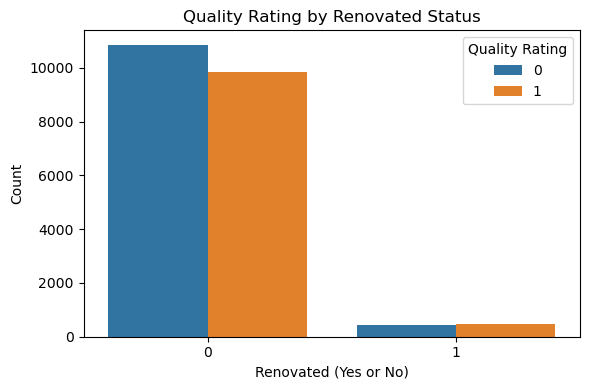

In [56]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='renovated', hue='quality_rating')
plt.title('Quality Rating by Renovated Status')
plt.xlabel('Renovated (Yes or No)')
plt.ylabel('Count')
plt.legend(title='Quality Rating')
plt.tight_layout()
plt.show()


**3. Point-Biserial Correlation** gives insight into how **each numerical feature is linearly associated with the binary `quality_rating` variable** (likely high vs. low quality). 

---

###  **Understanding the Output:**

Each line shows:
- **Correlation coefficient** (between -1 and +1):
  - **Positive** = as the feature increases, quality rating tends to be higher.
  - **Negative** = as the feature increases, quality rating tends to be lower.
  - **Closer to ±1** = stronger correlation.
- **p-value**:
  - Indicates **statistical significance**.
  - A p-value of `0.0000` (rounded) implies the correlation is **highly statistically significant** (typically p < 0.05 is considered significant).

---

###  **Top Positively Correlated Features**:
1. **`ceil_measure` (0.573)** – Larger main floor area strongly indicates higher quality.
2. **`room_bath` (0.555)** – More bathrooms are linked with better quality.
3. **`living_measure15` (0.557)** – Renovated living space is a good indicator of quality.
4. **`ceil` (0.457)** – More floors are associated with higher quality.
5. **`price` (0.455)** – Expensive houses tend to be of higher quality.

---

### **Negatively Correlated Features** (Linked to lower quality):
1. **`Age_of_the_property` (-0.422)** – Older properties are likely to have lower quality.
2. **`condition` (-0.143)** – Possibly, condition scale is reversed (lower value = better?), or older/poor-maintained houses are scoring worse.

---

### **Weak Feature**:
- **`sight` (0.184)** – Slight positive impact, maybe aesthetics/views influence quality perception.
- **`lot_measure15` (0.074)**, **`total_area` (0.087)** – Minimal correlation. These don’t contribute much in distinguishing quality.
- **`basement` (0.107)** – Slight impact; perhaps only finished basements matter?

---

### **Insights:**
- Focus on **ceil_measure, living area, number of baths/floors**, and **age** to predict or explain property quality.
- Features with low correlation can be deprioritized or tested further for non-linear effects or interaction terms.
- You might consider **transforming or combining features** like total area or basement to better capture quality influence.


In [58]:


print("Point-Biserial Correlation with Quality Rating:\n")
for col in numerical:
    corr, p = pointbiserialr(df[col], df['quality_rating'])
    print(f"{col}: Correlation = {corr:.3f}, p-value = {p:.4f}")


Point-Biserial Correlation with Quality Rating:

price: Correlation = 0.455, p-value = 0.0000
room_bed: Correlation = 0.271, p-value = 0.0000
room_bath: Correlation = 0.555, p-value = 0.0000
ceil: Correlation = 0.457, p-value = 0.0000
sight: Correlation = 0.184, p-value = 0.0000
condition: Correlation = -0.143, p-value = 0.0000
ceil_measure: Correlation = 0.573, p-value = 0.0000
basement: Correlation = 0.107, p-value = 0.0000
living_measure15: Correlation = 0.557, p-value = 0.0000
lot_measure15: Correlation = 0.074, p-value = 0.0000
total_area: Correlation = 0.087, p-value = 0.0000
Age_of_the_property: Correlation = -0.422, p-value = 0.0000


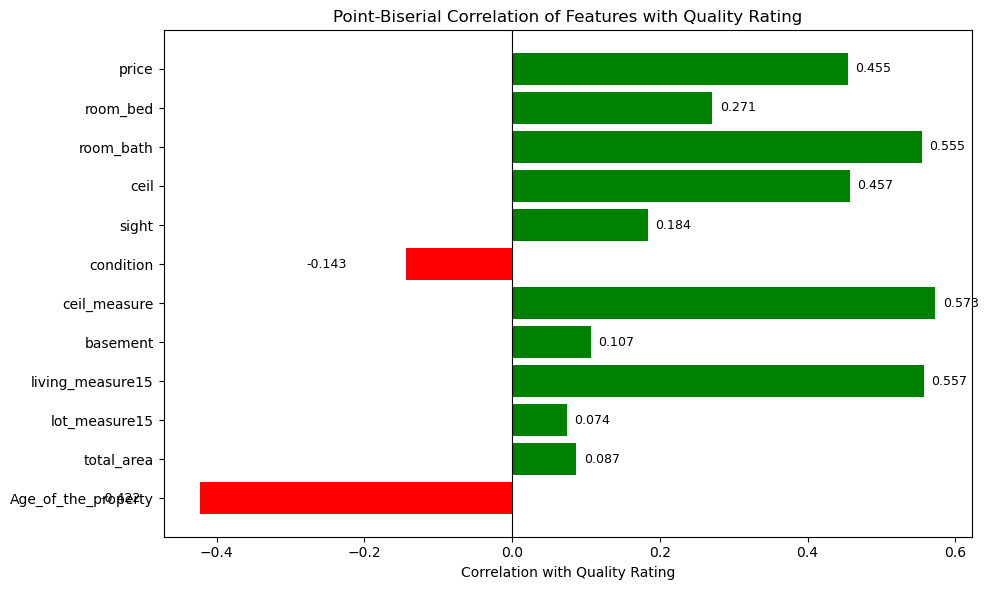

In [59]:
# Manually define the correlation data
data = {
    'Feature': [
        'price', 'room_bed', 'room_bath', 'ceil', 'sight', 'condition',
        'ceil_measure', 'basement', 'living_measure15', 'lot_measure15',
        'total_area', 'Age_of_the_property'
    ],
    'Correlation': [
        0.455, 0.271, 0.555, 0.457, 0.184, -0.143,
        0.573, 0.107, 0.557, 0.074, 0.087, -0.422
    ]
}

df_corr = pd.DataFrame(data)

#Set color based on correlation sign
colors = df_corr['Correlation'].apply(lambda x: 'green' if x > 0 else 'red')

#Plot horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(df_corr['Feature'], df_corr['Correlation'], color=colors)
plt.xlabel('Correlation with Quality Rating')
plt.title('Point-Biserial Correlation of Features with Quality Rating')
plt.axvline(0, color='black', linewidth=0.8)
plt.gca().invert_yaxis()  # So that higher correlations are on top

#Annotate each bar
for bar in bars:
    plt.text(
        bar.get_width() + 0.01 if bar.get_width() > 0 else bar.get_width() - 0.08,
        bar.get_y() + bar.get_height() / 2,
        f'{bar.get_width():.3f}',
        va='center',
        ha='left' if bar.get_width() > 0 else 'right',
        fontsize=9
    )

plt.tight_layout()
plt.show()


**3.1. Correlation and Feature Relationships Correlation Heatmap (Numerical Features)**
- This heatmap visualizes the **correlation coefficients** between various numerical features in your dataset and the **`quality_rating`**, helping to identify which features most influence or relate to property quality.

---
#### Strong Positive Correlations with `quality_rating`:
These features are more predictive of a property's quality:
- **`ceil_measure` (0.57)**: Indicates that the square footage above ground is highly indicative of better quality.
- **`room_bath` (0.55)**: More bathrooms are generally associated with higher quality.
- **`living_measure15` (0.56)**: Living space after renovation is strongly related to perceived quality.
- **`room_bed` (0.27)**: Modest positive relationship—more bedrooms slightly improve quality.
- **`ceil` (0.46)**: More floors (stories) moderately associate with better quality.

---
  
#### Weak or Negative Correlations:
- **`condition` (-0.14)**: Interestingly, the condition rating doesn't correlate strongly or positively with the quality rating—suggests that buyers might value other structural or aesthetic features more.
- **`basement` (0.11)** and **`lot_measure15` (0.074)**: Weak positive impact—implying lot size and basement area play minor roles.
- **`sight` (0.18)**: Scenic view has a low but positive correlation—likely more of a luxury bonus.

---

#### Feature Interrelationships:
- **`room_bath` ↔ `ceil_measure` (0.68)**: Homes with more bathrooms tend to have larger above-ground space.
- **`living_measure15` ↔ `ceil_measure` (0.73)**: Post-renovation living space is closely tied to the overall ceiling area.
- **`room_bath` ↔ `living_measure15` (0.57)**: More bathrooms tend to exist in homes with more living space.

---

### Insight:
- You can **prioritize `ceil_measure`, `room_bath`, and `living_measure15`** as top predictors when modeling or evaluating property quality.
- Consider that **subjective factors like "condition" may not align with the grading system used for `quality_rating`**, which might be more structural or based on other metrics.
- Use **multicollinearity checks** in your model, especially between highly correlated predictors like `ceil_measure` and `living_measure15`.


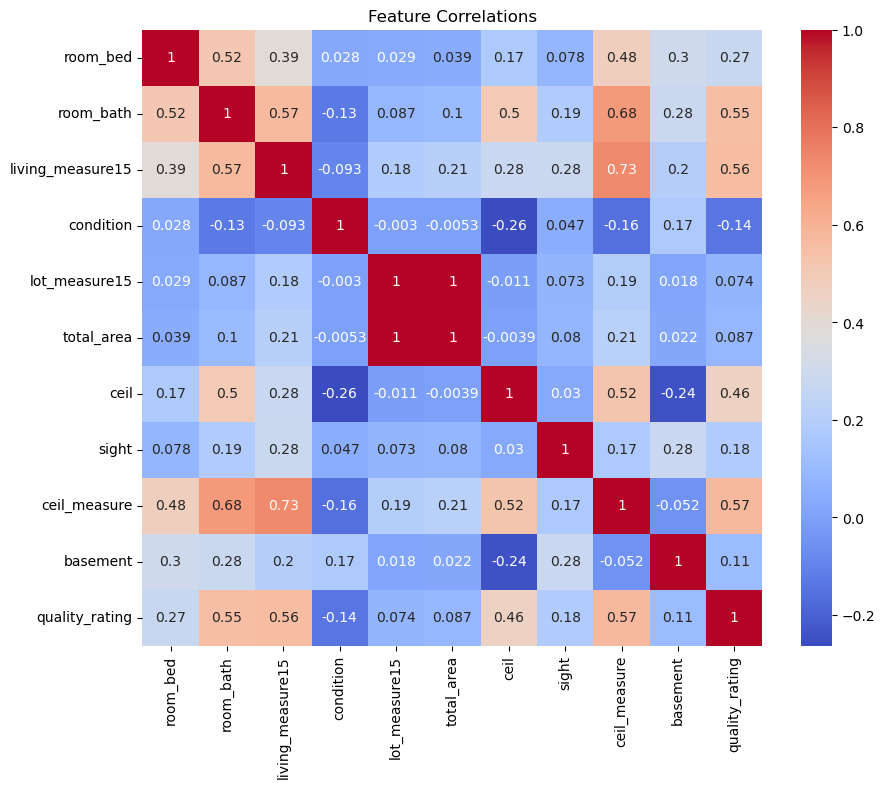

In [61]:
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols + ['quality_rating']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlations')
plt.show()


**4. Feature Distribution and Comparison by quality_rating**
- For Numerical Features (e.g., room_bed, room_bath, living_measure, condition) Boxplots.
- Visualize how features differ by quality class. Helps identify important predictors.

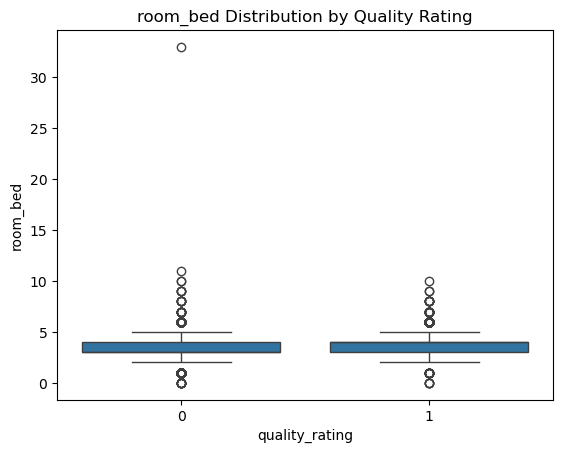

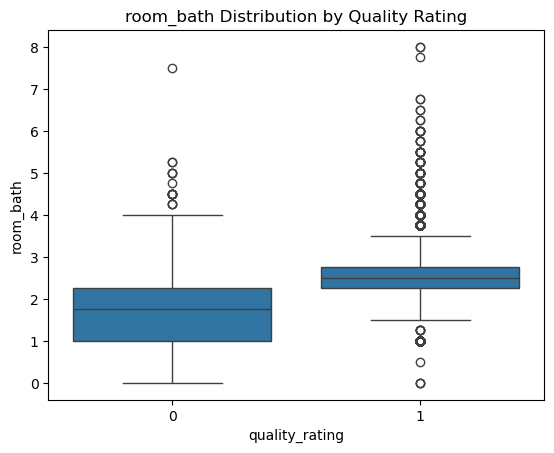

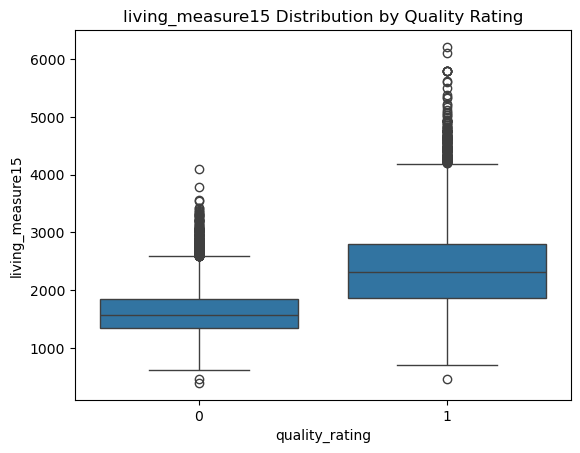

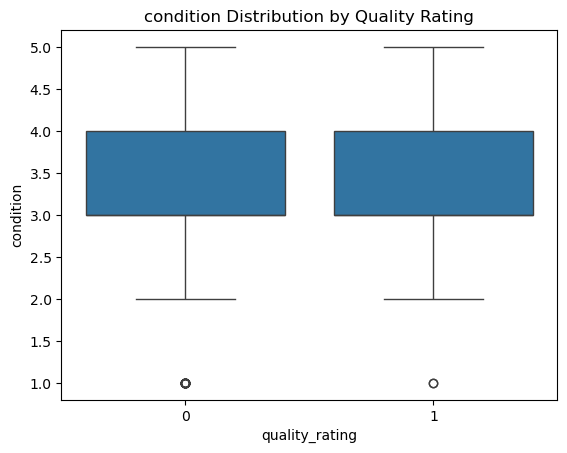

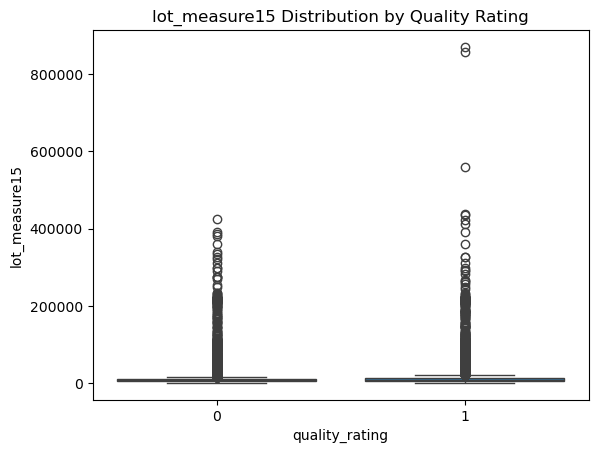

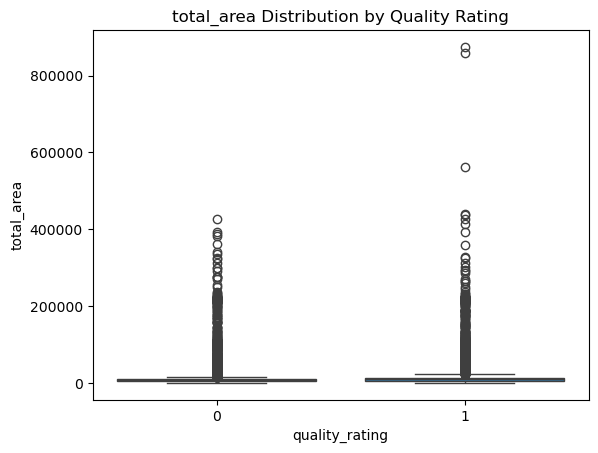

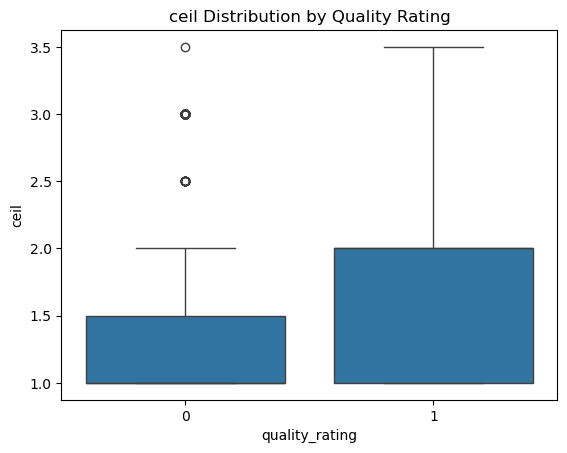

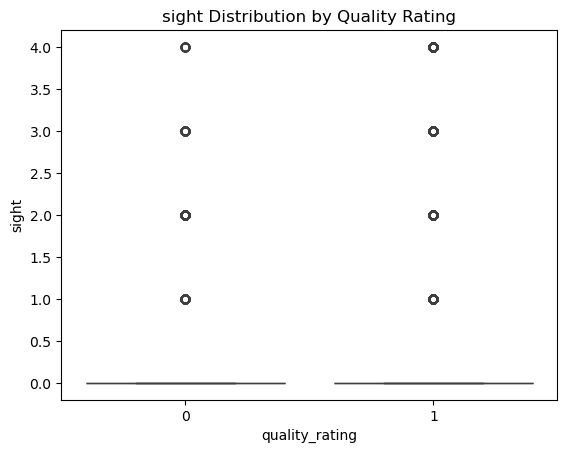

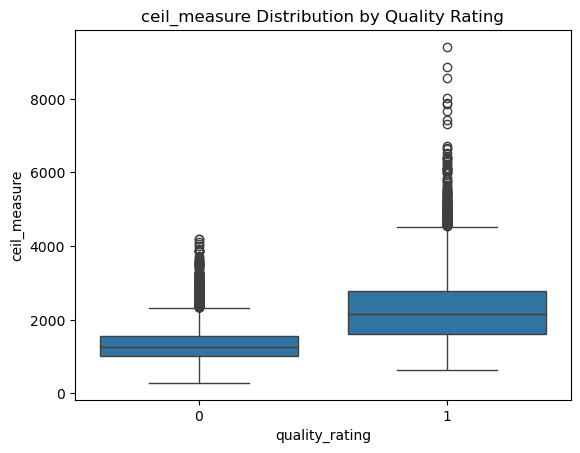

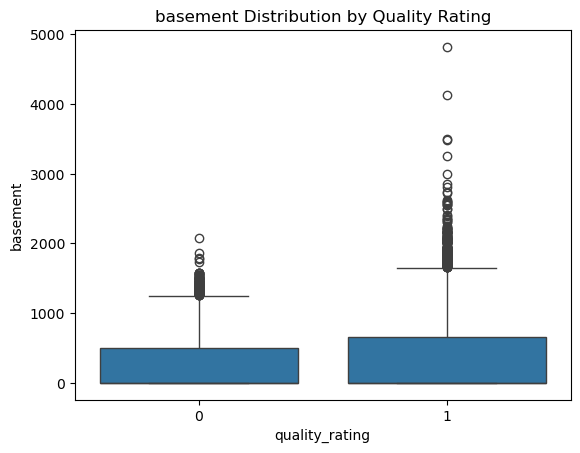

In [63]:

for col in num_cols:
    sns.boxplot(data=df, x='quality_rating', y=col)
    plt.title(f'{col} Distribution by Quality Rating')
    plt.show()


**5. Categorical Features (e.g., coast, furnished) Stacked Bar Charts**

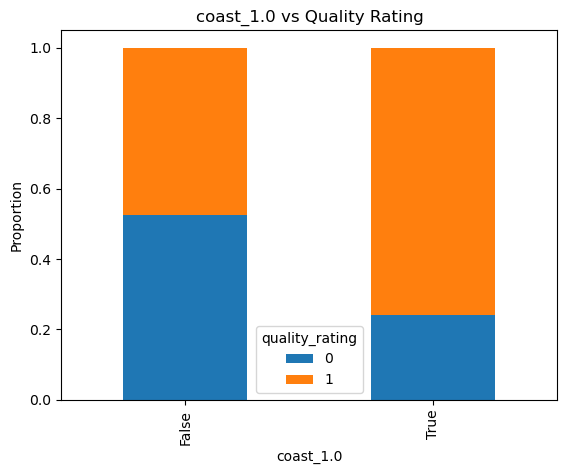

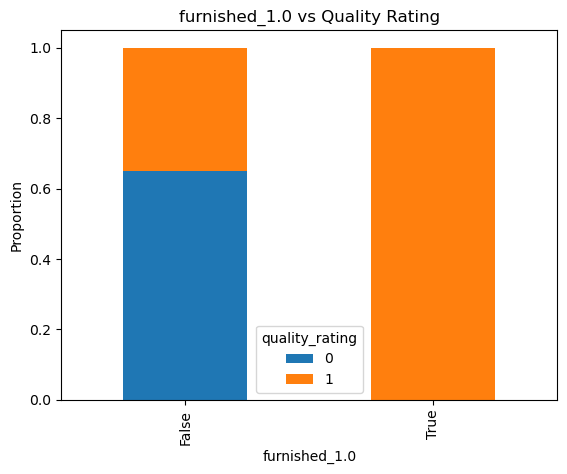

In [65]:
for col in ['coast_1.0', 'furnished_1.0']:
    ct = pd.crosstab(df[col], df['quality_rating'], normalize='index')
    ct.plot(kind='bar', stacked=True)
    plt.title(f'{col} vs Quality Rating')
    plt.ylabel('Proportion')
    plt.show()


## 7: Build the Model

In [67]:
df.columns

Index(['price', 'room_bed', 'room_bath', 'ceil', 'sight', 'condition',
       'ceil_measure', 'basement', 'City', 'State', 'Country',
       'living_measure15', 'lot_measure15', 'year', 'month', 'renovated',
       'quality_rating', 'total_area', 'Age_of_the_property', 'coast_1.0',
       'furnished_1.0'],
      dtype='object')

**7.1. Selecting Features and Target**
- You can use the following code to select the important features and the target variable (quality_rating) from your DataFrame df.

In [69]:

# Select important features (based on your EDA)
features = df[['renovated','furnished_1.0','coast_1.0','ceil_measure','living_measure15','room_bath','price','ceil',
               'room_bed','sight','Age_of_the_property']]
target = df['quality_rating']

 **7.2. Train/Test Split & Scaling**

In [71]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**7.3. Train a Random Forest Classifier**

In [73]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Low Quality', 'High Quality']))


[[2071  239]
 [ 269 1744]]
              precision    recall  f1-score   support

 Low Quality       0.89      0.90      0.89      2310
High Quality       0.88      0.87      0.87      2013

    accuracy                           0.88      4323
   macro avg       0.88      0.88      0.88      4323
weighted avg       0.88      0.88      0.88      4323



In [74]:
# Classification_report
print(classification_report(y_test, y_pred, target_names=['Low Quality', 'High Quality']))


              precision    recall  f1-score   support

 Low Quality       0.89      0.90      0.89      2310
High Quality       0.88      0.87      0.87      2013

    accuracy                           0.88      4323
   macro avg       0.88      0.88      0.88      4323
weighted avg       0.88      0.88      0.88      4323



In [75]:
# Confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[2071  239]
 [ 269 1744]]


**7.3.2. ROC-AUC Score**

In [77]:
# ROC-AUC Score
y_prob_rf = model.predict_proba(X_test_scaled)[:, 1]  
auc_rf = roc_auc_score(y_test, y_prob_rf)
print(f"ROC-AUC Score: {auc_rf:.4f}")

ROC-AUC Score: 0.9543


**7.3.3 ROC and AUC curve**
- AUC close to 1.0: Excellent model
- AUC ≈ 0.5: No better than random guessing
- Curve bows toward top-left corner: Strong classifier

ROC-AUC Score: 0.9543


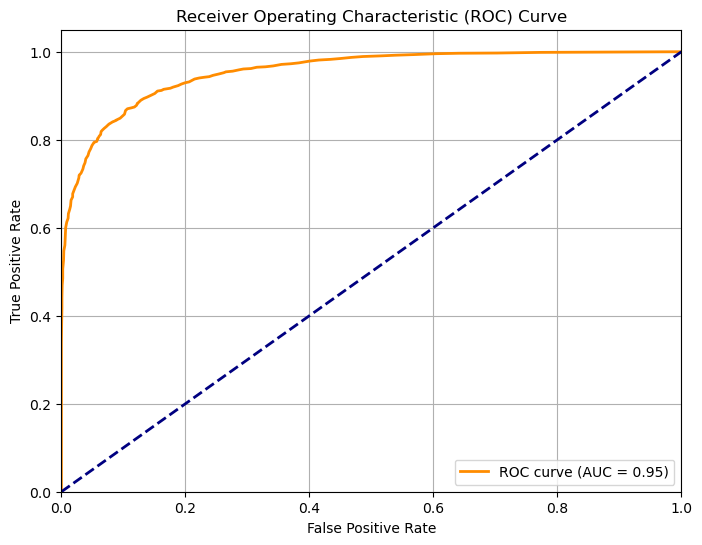

In [79]:
# ROC-AUC Score
y_prob_rf = model.predict_proba(X_test_scaled)[:, 1]  
auc_rf = roc_auc_score(y_test, y_prob_rf)
print(f"ROC-AUC Score: {auc_rf:.4f}")

# Get the predicted probabilities (for the positive class)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# Compute False Positive Rate, True Positive Rate
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute AUC
auc_score = roc_auc_score(y_test, y_prob)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


**7.3.4 Confusion Matrix**
- Diagonal values (2071 & 1744) are correct predictions.
- Off-diagonal values (239 & 269) are misclassifications.

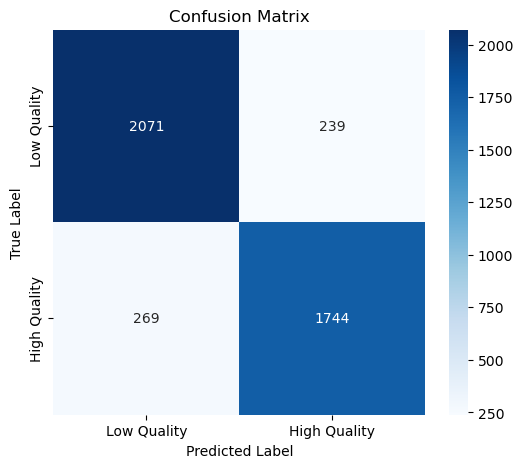

In [81]:
cm = confusion_matrix(y_test, y_pred)

# Define class names (customizable)
class_names = ['Low Quality', 'High Quality']

# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


**7.4. Train a Logistic Regression**

In [83]:
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

**7.4.1. Predictions**

In [85]:

y_pred_lr = log_reg.predict(X_test_scaled)


**7.4.2 Confusion Matrix**

In [87]:
# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("Confusion Matrix:\n", cm_lr)

Confusion Matrix:
 [[2038  272]
 [ 378 1635]]


**7.4.3 Classification Report**

In [89]:
# Classification Report:
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr, target_names=['Low Quality', 'High Quality']))



Classification Report:
               precision    recall  f1-score   support

 Low Quality       0.84      0.88      0.86      2310
High Quality       0.86      0.81      0.83      2013

    accuracy                           0.85      4323
   macro avg       0.85      0.85      0.85      4323
weighted avg       0.85      0.85      0.85      4323



**7.4.4. ROC-AUC Score**

In [91]:
# ROC-AUC Score:
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:, 1]
auc_lr = roc_auc_score(y_test, y_prob_lr)
print(f"\nROC-AUC Score: {auc_lr:.4f}")


ROC-AUC Score: 0.9357


**7.4.5 Plot ROC Curve**

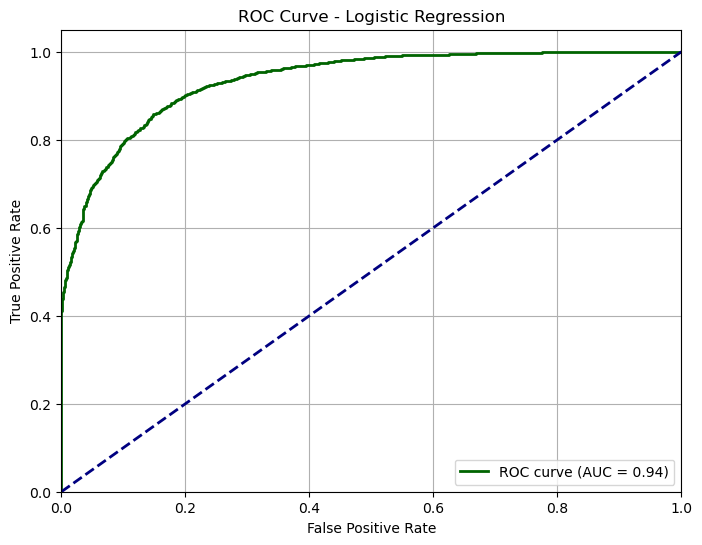

In [93]:
# ROC-AUC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_lr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkgreen', lw=2, label=f'ROC curve (AUC = {auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

**7.4.6 Plot Confusion Matrix**

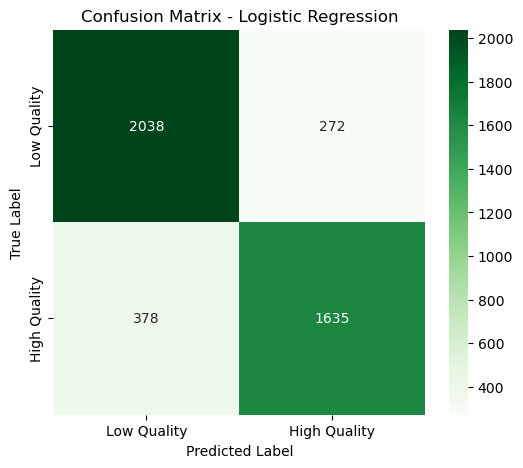

In [95]:

plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', xticklabels=['Low Quality', 'High Quality'], yticklabels=['Low Quality', 'High Quality'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


**7.5. Compare Random Forest vs Logistic Regression side-by-side**

---
**7.5.1 Compare Metrics**

In [97]:
# Define a function to summarize model performance
def get_metrics(y_true, y_pred, y_prob):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_prob)
    }


In [98]:
# Collect all metrics
rf_metrics = get_metrics(y_test, y_pred, y_prob_rf)
lr_metrics = get_metrics(y_test, y_pred_lr, y_prob_lr)

In [99]:
# Display in a clean DataFrame
comparison_df = pd.DataFrame({
    'Random Forest': rf_metrics,
    'Logistic Regression': lr_metrics
})

print(comparison_df.T)


                     Accuracy  Precision    Recall  F1-Score   ROC-AUC
Random Forest        0.882489   0.879476  0.866369  0.872873  0.954340
Logistic Regression  0.849641   0.857368  0.812221  0.834184  0.935679


**7.5.2 Plot ROC Curves Together**

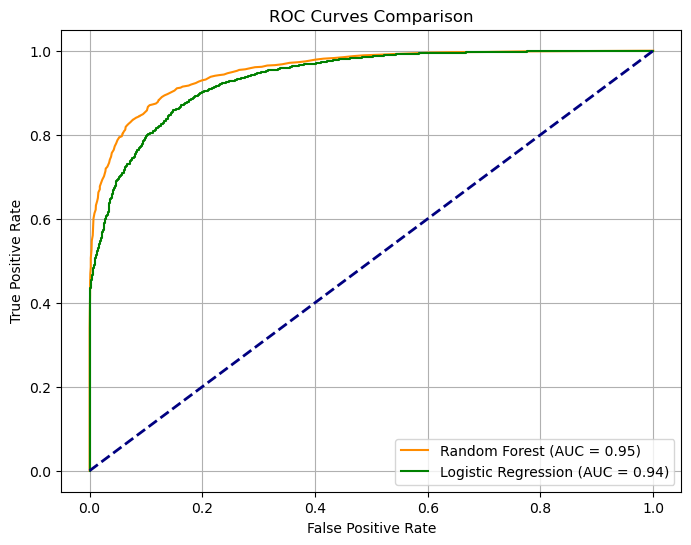

In [101]:
# ROC for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
# ROC for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})', color='darkorange')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_prob_lr):.2f})', color='green')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

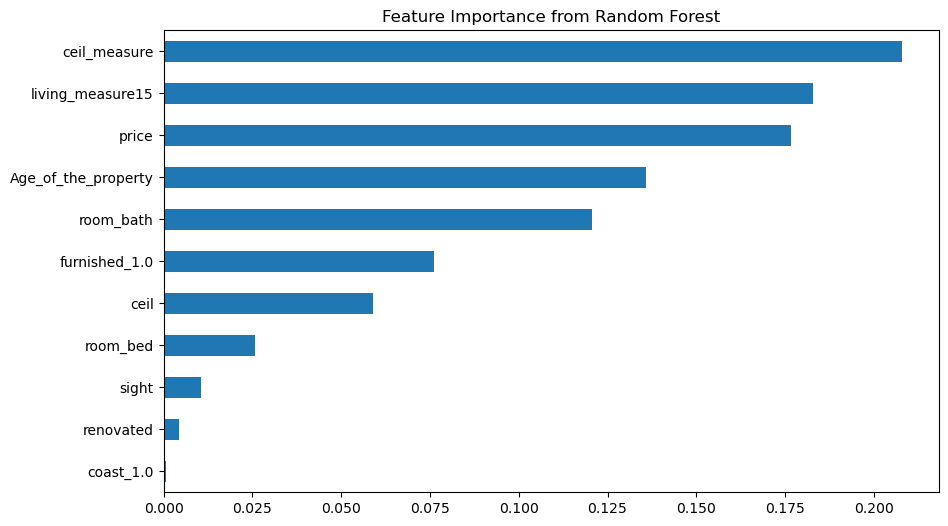

In [102]:
# Important Features: 
importances = model.feature_importances_
feature_names = features.columns

feat_importances = pd.Series(importances, index=feature_names)
feat_importances.sort_values().plot(kind='barh', figsize=(10,6))
plt.title('Feature Importance from Random Forest')
plt.show()


### Random Forest is perform much better than Logistic Regression than I choose Random forest